In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation 
from PIL import Image

import os

from IPython.display import HTML
from tqdm.auto import tqdm

import sys
sys.path.append("../")
from models import ConvolutionalAE, ConvolutionalVAE

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")

In [3]:
print(gpu, device)

False cpu


# Config

In [64]:
experiment_name = f"convolutional_autoencoder_v10.3"
model_type = "vae" if "vae" in experiment_name else "autoencoder"

batch_size = 64

num_layers = 4
max_filters = 512
image_size = 64
latent_dim = 2048
small_conv = True  # To use the 1x1 convolution layer

data_prefix = f"../data/original/"
data_folder = os.path.join(data_prefix, "original_data")

model_prefix = f"../outputs/"
model_path = os.path.join(model_prefix, f"{experiment_name}/model.pt")

output_prefix = f""
output_dir = os.path.join(output_prefix, f"{experiment_name}_fusions")

# Utility Functions

In [65]:
def show_image(image, model_output=False):
    if model_output:
        image = image.detach().squeeze(0)
    plt.imshow(image.permute(1, 2, 0).numpy())

In [66]:
def animate(image, axis):
    axis.imshow(image.permute(1, 2, 0).numpy())

In [67]:
def create_animation(frames):
    fig, axis = plt.subplots(1, 1, dpi=80)
    plt.tight_layout()
    plt.close()
    return animation.FuncAnimation(fig=fig, func=animate, frames=frames, fargs=(axis, ), interval=300, repeat=True)

# Load Model

In [68]:
def load_model(model_type, max_filters, num_layers, input_image_dimensions, latent_dim, small_conv, model_path, device):
    if model_type == "autoencoder":
        model = ConvolutionalAE(max_filters=max_filters, num_layers=num_layers, input_image_dimensions=image_size, 
                                latent_dim=latent_dim, small_conv=small_conv)
    else:
        model = ConvolutionalVAE(max_filters=max_filters, num_layers=num_layers, input_image_dimensions=image_size, 
                                 latent_dim=latent_dim, small_conv=small_conv)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

In [69]:
model = load_model(model_type, max_filters, num_layers, image_size, latent_dim, small_conv, model_path, device)

In [70]:
print(model)

ConvolutionalAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=8192, 

# Load & Preprocess Data

In [71]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),
])

In [72]:
def load_data(data_folder, image_size, transform):
    pokemon = {}
    background = Image.new("RGBA", (image_size, image_size), (255, 255, 255))
    for file in os.listdir(data_folder):
        id_ = file.split('.')[0].split('_')[0].split('-')[0]
        form = '_'.join(file.split('.')[0].split('_')[1:])
        image = Image.open(os.path.join(data_folder, file))
        image = image.resize((image_size, image_size), resample=Image.BICUBIC).convert("RGBA")
        image = Image.alpha_composite(background, image).convert("RGB")
        if id_ not in pokemon:
            pokemon[id_] = {}
        pokemon[id_][form] = transform(image)
    return pokemon

In [73]:
pokemon = load_data(data_folder, image_size, transform)

In [74]:
image1 = pokemon['001']['base_hgss']
image2 = pokemon['025']['base_hgss']

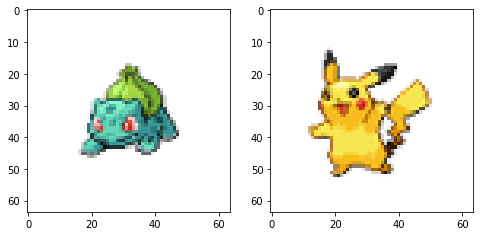

In [75]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
show_image(image1)
fig.add_subplot(1, 2, 2)
show_image(image2)

In [76]:
if model_type == "vae":
    gen1, _, _ = model(image1.unsqueeze(0))
    gen2, _, _ = model(image2.unsqueeze(0))
else:
    gen1 = model(image1.unsqueeze(0))
    gen2 = model(image2.unsqueeze(0))
gen1 = gen1.squeeze(0).detach()
gen2 = gen2.squeeze(0).detach()

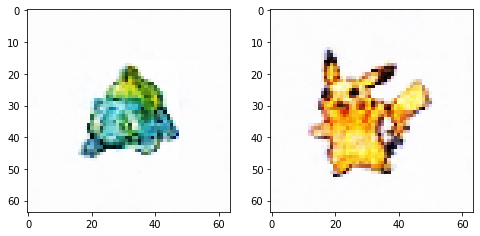

In [77]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
show_image(gen1)
fig.add_subplot(1, 2, 2)
show_image(gen2)

# Fusions

In [58]:
def fusion_add(image1, image2, weights=(1,1)):
    image1 = image1.clone()
    image2 = image2.clone()
    return torch.add(torch.mul(image1, weights[0]), torch.mul(image2, weights[1])) / (weights[0] + weights[1])

In [59]:
def fusion_mix_match(image1, image2, num_dims):
    image1 = image1.clone()
    image2 = image2.clone()
    feature_dims = np.random.randint(0, image1.shape[1], num_dims)
    image1[0, feature_dims] = image2[0, feature_dims]
    return image1

In [60]:
def get_latent_representations(image1, image2, model_type, model):
    if model_type == "autoencoder":
        output1 = model.encoder(image1.unsqueeze(0)).detach()
        output2 = model.encoder(image2.unsqueeze(0)).detach()
        return output1, output2
    else:
        _, output1_mu, output1_log_var = model(image1.unsqueeze(0))
        _, output2_mu, output2_log_var = model(image2.unsqueeze(0))
        output1_mu = output1_mu.detach()
        output1_log_var = output1_log_var.detach()
        output2_mu = output2_mu.detach()
        output2_log_var = output2_log_var.detach()
        return output1_mu, output1_log_var, output2_mu, output2_log_var

## Add

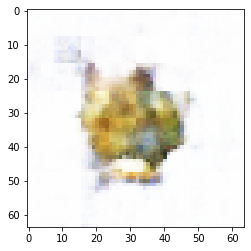

In [61]:
# Individual
weights = (0.5, 0.5)
if model_type == "autoencoder":
    output1, output2 = get_latent_representations(image1, image2, model_type, model)
    combined = fusion_add(output1, output2, weights=weights)
else:
    output1_mu, output1_log_var, output2_mu, output2_log_var = get_latent_representations(image1, image2, model_type, model)
    combined_mu = fusion_add(output1_mu, output2_mu, weights=weights)
    combined_log_var = fusion_add(output1_log_var, output2_log_var, weights=weights)
    combined = model.reparameterize(combined_mu, combined_log_var)
show_image(model.decoder(combined), model_output=True)

In [62]:
# Animation
to_animate = []
for i in np.arange(0.0, 1.0, 0.1):
    if model_type == "autoencoder":
        combined = fusion_add(output1, output2, weights=(i, 1-i))
    else:
        output1_mu, output1_log_var, output2_mu, output2_log_var = get_latent_representations(
            image1, image2, model_type, model
        )
        combined_mu = fusion_add(output1_mu, output2_mu, weights=(i, 1-i))
        combined_log_var = fusion_add(output1_log_var, output2_log_var, weights=(i, 1-i))
        combined = model.reparameterize(combined_mu, combined_log_var)
    out = model.decoder(combined).detach().squeeze(0)
    to_animate.append(out)
anim = create_animation(to_animate)
HTML(anim.to_html5_video())

In [ ]:
# Bulk
weights = (0.5, 0.5)
spritesheet = 'base_hgss'
new_output_dir = output_dir + '_add'
if not os.path.exists(new_output_dir):
    os.mkdir(new_output_dir)
already_done = os.listdir(new_output_dir)

for base in tqdm(range(1, 152)):
    for fusion in tqdm(range(1, 152), leave=False):
        
        # Skip if already done
        file_name = f"{base}.{fusion}.png"
        if file_name in already_done:
            continue
        
        # Get images
        image1 = pokemon[f"{base:03}"][spritesheet]
        image2 = pokemon[f"{fusion:03}"][spritesheet]
        
        # Get representations
        if model_type == "autoencoder":
            output1, output2 = get_latent_representations(image1, image2, model_type, model)
        else:
            output1_mu, output1_log_var, output2_mu, output2_log_var = get_latent_representations(
                image1, image2, model_type, model
            )
            
        # Combine representations
        if model_type == "autoencoder":
            combined = fusion_add(output1, output2, weights=weights)
        else:
            combined_mu = fusion_add(output1_mu, output2_mu, weights=weights)
            combined_log_var = fusion_add(output1_log_var, output2_log_var, weights=weights)
            combined = model.reparameterize(combined_mu, combined_log_var)
            
        # Decode representation
        out = model.decoder(combined).detach().squeeze(0).permute(1, 2, 0).numpy() * 255
        
        # Save representation
        Image.fromarray(out.astype(np.uint8)).save(os.path.join(new_output_dir, file_name))

## Recombine

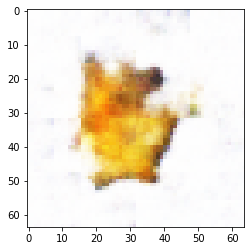

In [22]:
# Single
num_dims = 512
if model_type == "autoencoder":
    output1 = model.encoder(image1.unsqueeze(0)).detach()
    output2 = model.encoder(image2.unsqueeze(0)).detach()
    combined = fusion_mix_match(output1, output2, num_dims=num_dims)
else:
    output1_mu, output1_log_var, output2_mu, output2_log_var = get_latent_representations(
        image1, image2, model_type, model
    )
    
    combined_mu = fusion_mix_match(output1_mu, output2_mu, num_dims=num_dims)
    combined_log_var = fusion_mix_match(output1_log_var, output2_log_var, num_dims=num_dims)
    combined = model.reparameterize(combined_mu, combined_log_var)
show_image(model.decoder(combined), model_output=True)

In [23]:
# Animation
to_animate = []
for num_dims in [2, 4, 8, 16, 32, 64, 128, 256, 512, 768, 1024, 1596, 2048]:
    if model_type == "autoencoder":
        output1 = model.encoder(image1.unsqueeze(0)).detach()
        output2 = model.encoder(image2.unsqueeze(0)).detach()
        combined = fusion_mix_match(output1, output2, num_dims=num_dims)
    else:
        output1_mu, output1_log_var, output2_mu, output2_log_var = get_latent_representations(
            image1, image2, model_type, model
        )

        combined_mu = fusion_mix_match(output1_mu, output2_mu, num_dims=num_dims)
        combined_log_var = fusion_mix_match(output1_log_var, output2_log_var, num_dims=num_dims)
        combined = model.reparameterize(combined_mu, combined_log_var)
    out = model.decoder(combined).detach().squeeze(0)
    to_animate.append(out)
anim = create_animation(to_animate)
HTML(anim.to_html5_video())

In [ ]:
# Bulk
num_dims = latent_dim // 2
spritesheet = 'base_hgss'
new_output_dir = output_dir + '_mix_match'
if not os.path.exists(new_output_dir):
    os.mkdir(new_output_dir)
already_done = os.listdir(new_output_dir)

for base in tqdm(range(1, 152)):
    for fusion in tqdm(range(1, 152), leave=False):
        
        # Skip if already done
        file_name = f"{base}.{fusion}.png"
        if file_name in already_done:
            continue
        
        # Get images
        image1 = pokemon[f"{base:03}"][spritesheet]
        image2 = pokemon[f"{fusion:03}"][spritesheet]
        
        # Get representations
        if model_type == "autoencoder":
            output1 = model.encoder(image1.unsqueeze(0)).detach()
            output2 = model.encoder(image2.unsqueeze(0)).detach()
        else:
            output1_mu, output1_log_var, output2_mu, output2_log_var = get_latent_representations(
                image1, image2, model_type, model
            )
            
        # Combine representations
        if model_type == "autoencoder":
            combined = fusion_mix_match(output1, output2, num_dims=num_dims)
        else:
            combined_mu = fusion_mix_match(output1_mu, output2_mu, num_dims=num_dims)
            combined_log_var = fusion_mix_match(output1_log_var, output2_log_var, num_dims=num_dims)
            combined = model.reparameterize(combined_mu, combined_log_var)
            
        # Decode representation
        out = model.decoder(combined).detach().squeeze(0).permute(1, 2, 0).numpy() * 255
        
        # Save representation
        Image.fromarray(out.astype(np.uint8)).save(os.path.join(new_output_dir, file_name))